In [1]:
from ROOT import TFile
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

Welcome to JupyROOT 6.22/06


In [2]:
path="/home/aa/EPPT/run/"

In [3]:
load_file = TFile(path+"B5.root", "READ")
tree = load_file.Get('B5')

In [129]:
#Event 0 to initiate numpy array and just vstack after
tree.GetEntry(0)
dc1_xpos = np.array( getattr(tree, 'Dc1HitsVector_x') )
dc1_ypos = np.array( getattr(tree, 'Dc1HitsVector_y') )
dc1_zpos = np.array( getattr(tree, 'Dc1HitsVector_z') )


for entry in range(1, tree.GetEntries()):
    tree.GetEntry(entry)
    if (np.array( getattr(tree, 'Dc1HitsVector_x') ).size >= 5):
       dc1_xpos=np.vstack( ( dc1_xpos , np.array( getattr( tree , 'Dc1HitsVector_x' ) )[:5] ) )
    else : 
        print("Too less x hits. Reject event #", entry)
        
    if (np.array( getattr(tree, 'Dc1HitsVector_y') ).size >= 5):
       dc1_ypos=np.vstack( ( dc1_ypos , np.array( getattr( tree , 'Dc1HitsVector_y' ) )[:5] ) )
    else : 
        print("Too less y hits. Reject event #", entry)
    
    if (np.array( getattr(tree, 'Dc1HitsVector_z') ).size >= 5):
       dc1_zpos=np.vstack( ( dc1_zpos , np.array( getattr( tree , 'Dc1HitsVector_z' ) )[:5] ) )
    else : 
        print("Too less z hits. Reject event #", entry)

Too less x hits. Reject event # 169
Too less y hits. Reject event # 169
Too less z hits. Reject event # 169


In [76]:
dc2_xpos = np.array( getattr(tree, 'Dc2HitsVector_x') )
dc2_ypos = np.array( getattr(tree, 'Dc2HitsVector_y') )
dc2_zpos = np.array( getattr(tree, 'Dc2HitsVector_z') )

for entry in range(1, tree.GetEntries()):
    tree.GetEntry(entry)
    if (np.array( getattr(tree, 'Dc2HitsVector_x') ).size >= 5):
       dc2_xpos=np.vstack( ( dc2_xpos , np.array( getattr( tree , 'Dc2HitsVector_x' ) )[:5] ) )
    else : 
        print("Too less x hits. Reject event #", entry)
        
    if (np.array( getattr(tree, 'Dc2HitsVector_y') ).size >= 5):
       dc2_ypos=np.vstack( ( dc2_ypos , np.array( getattr( tree , 'Dc2HitsVector_y' ) )[:5] ) )
    else : 
        print("Too less y hits. Reject event #", entry)
    
    if (np.array( getattr(tree, 'Dc2HitsVector_z') ).size >= 5):
       dc2_zpos=np.vstack( ( dc2_zpos , np.array( getattr( tree , 'Dc2HitsVector_z' ) )[:5] ) )
    else : 
        print("Too less z hits. Reject event #", entry)

Too less x hits. Reject event # 169
Too less y hits. Reject event # 169
Too less z hits. Reject event # 169


In [125]:
def linear(x,a,b):
    return a*x+b

zPosDC1 = np.array([-6.25, -5.75, -5.25, -4.75, -4.25])
zPosDC2 = np.array([2.25, 2.75, 3.25, 3.75, 4.25])

#Set x values to the good units
dc1_xpos_metres=dc1_xpos/1000
dc2_xpos_metres=dc2_xpos/1000

def compute_p(event,B,L,plot=False,save=False):

    popt1,pcov1 = optimize.curve_fit(linear,zPosDC1,dc1_xpos_metres[event])
    z1=np.linspace(-6.25,0,626)
    x1=linear(x=z1,a=popt1[0],b=popt1[1])

    popt2,pcov2 = optimize.curve_fit(linear,zPosDC2,dc2_xpos_metres[event])
    z2=np.linspace(-0.5,4.25,476)
    x2=linear(x=z2,a=popt2[0],b=popt2[1])

    #Intersection point 
    z_intersect = (popt2[1] - popt1[1]) / (popt1[0] - popt2[0])
    x_intersect = popt1[0] * z_intersect + popt1[1]

    h = abs(zPosDC2[0] - z_intersect)
    X = abs(dc2_xpos_metres[event][0] - x_intersect)
    theta = np.arcsin(X/h)
    p = (0.3*B*L) / (2 * np.sin(theta/2) )

    if plot : 
    
        fig = plt.figure(figsize=(8,8))

        axes= fig.add_axes([0.1,0.1,0.8,0.8])

        axes.scatter(zPosDC1,dc1_xpos_metres[event],label='DC1')
        axes.scatter(zPosDC2, dc2_xpos_metres[event] , label='DC2')
        axes.plot(z1,x1)
        axes.plot(z2,x2)
        axes.scatter(z_intersect,x_intersect,color='black')
        axes.set_ylim(-1.5E-2,1E-3)

        square=plt.Rectangle((-1,-1),2,2,fill=False)
        plt.gca().add_patch(square)



        plt.legend()

        plt.grid()
        if save : plt.savefig("event"+str(event)+".png")
    
        plt.title("Event #"+str(event))

        plt.show()
    
    return(p)



mu =  99.9511867859538
sigma =  1.3138090508300777


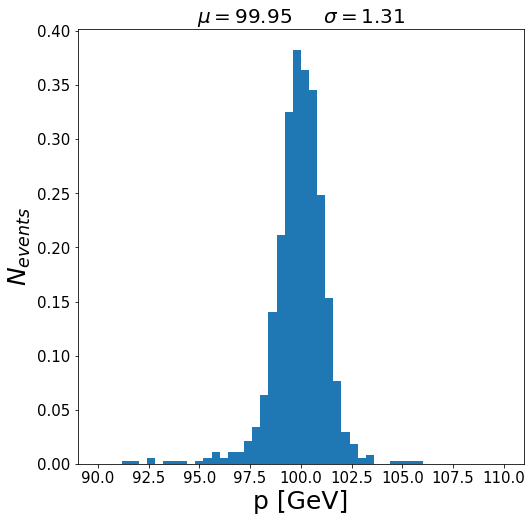

In [158]:
from scipy import stats 

p_values = []
for event in range(dc1_xpos_metres.shape[0]):
    p = compute_p(event,0.5,2)
    if p > 90 and p < 110 : 
        p_values.append(p)
fig = plt.figure(figsize=(8,8))
plt.hist(p_values,bins=50,range=(90,110),density=True);

 
m, s = stats.norm.fit(p_values) # get mean and standard deviation 

#plt.vlines(m,0,140,linestyles='dashed')
plt.xlabel('p [GeV]',fontsize=25)
plt.ylabel('$N_{events}$',fontsize=25)
plt.xticks(fontsize=15) 
plt.yticks(fontsize=15)
plt.title('$\mu=$'+str(round(m,2)) + '\t' + '$\sigma=$'+str(round(s,2)) ,fontsize=20 )


print("mu = ",m)
print("sigma = ",s)

           
           
           

In [148]:
print(np.sqrt(np.var(p_values)))

12.098842918697102
